## ***DSAA Assignment 2: Stock Price Prediction***

***Author: Peixian Ma(50011853)***

***Created Time: 2023.11.05***

### ***1 Brief Settings***

#### ***1-1 Import Packages***

In [1]:
import torch
import argparse

import tushare as ts
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm

#### ***1-2 Args Settings***

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--gpu', default=0, type=int, help='No. of GPU devicem, available when useGPU is True')
parser.add_argument('--epochs', default=100, type=int, help='training epochs')
parser.add_argument('--layers', default=2, type=int, help='number of hidden layers') 
# parser.add_argument('--input_size', default=14, type=int, help='dimenson size of input')
parser.add_argument('--hidden_size', default=32, type=int, help='dimenson size of hidden layers')
parser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
parser.add_argument('--sequence_length', default=20, type=int, help='input seq length')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--useGPU', default=False, type=bool, help='use GPU or not')
parser.add_argument('--batch_first', default=True, type=bool, help='put the batch size as the first dimenson of ndarray')
parser.add_argument('--dropout', default=0.1, type=float, help='dropout rate')
args = parser.parse_args(args=[])

device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() and args.useGPU else "cpu")
args.device = device

### ***2 Data Collection***

***Use Tushare Database to get the history data of these stocks***

#### ***2-1 Load Stock Dataset***

In [3]:
stock_code_dict = {
    '贵州茅台': '600519',
    '獐子岛': '002069',
    '沪深300': '399300',
    '中国石油': '601857'
}

guizhou_df = ts.get_hist_data(stock_code_dict['贵州茅台'])
zhangzi_df = ts.get_hist_data(stock_code_dict['獐子岛'])
hushen_df = ts.get_hist_data(stock_code_dict['沪深300'])
shiyou_df = ts.get_hist_data(stock_code_dict['中国石油'])

# print(guizhou_df)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


#### ***2-2 Brief View of Dataframe***

In [4]:
guizhou_df.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,1820.044243,1841.712878,1819.632401,1798.935016,32226.728076,-0.175592,0.007993,1820.142712,1821.113388,1823.524067,32263.789984,32309.067714,32364.421431,0.256645
std,148.707748,148.613016,147.925191,146.889458,17042.761085,32.933465,1.846726,145.206429,142.313276,136.207101,13400.612539,12223.547689,11042.052661,0.135794
min,1350.000000,1382.010000,1350.000000,1333.000000,11121.430000,-122.720000,-7.560000,1407.418000,1444.615000,1487.079000,13681.760000,15069.950000,16438.380000,0.090000
25%,1730.000000,1750.000000,1728.285000,1711.247500,20867.465000,-16.387500,-0.892500,1731.265000,1732.457250,1737.183000,23190.180000,23659.812500,23326.837500,0.170000
50%,1808.000000,1826.640000,1807.505000,1788.100000,27895.675000,-1.030000,-0.055000,1807.731000,1813.408500,1815.639500,29365.440000,30068.055000,31147.815000,0.220000
75%,1898.145000,1912.270000,1894.237500,1878.030000,37765.882500,15.305000,0.870000,1891.636500,1898.037750,1898.940500,36253.712500,36513.520000,37010.720000,0.300000
max,2265.000000,2320.000000,2271.000000,2240.010000,132098.050000,161.000000,9.500000,2241.534000,2231.517000,2193.921000,99097.820000,89104.700000,68816.070000,1.050000


In [5]:
zhangzi_df.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
count,606.000000,606.000000,606.000000,606.000000,6.060000e+02,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,3.688267,3.756353,3.690561,3.631337,1.123826e+05,0.001683,0.076056,3.687388,3.684033,3.679059,112334.224323,112269.036832,112318.066040,1.615429
std,0.506648,0.524363,0.502450,0.489122,1.505288e+05,0.099543,2.545557,0.492527,0.482485,0.467723,127043.620425,111364.077672,94772.071905,2.160699
min,2.760000,2.810000,2.750000,2.730000,4.280000e+03,-0.480000,-10.060000,2.802000,2.906000,2.930000,18939.660000,23956.530000,26588.450000,0.060000
25%,3.320000,3.390000,3.330000,3.262500,4.332675e+04,-0.040000,-1.197500,3.332500,3.341500,3.362250,47544.872500,50859.002500,50489.132500,0.630000
50%,3.690000,3.750000,3.680000,3.630000,6.408650e+04,0.000000,0.000000,3.677000,3.664500,3.674000,70850.190000,69356.105000,71833.040000,0.915000
75%,4.010000,4.100000,4.010000,3.960000,1.125245e+05,0.040000,1.170000,3.991500,3.999500,3.995000,115247.230000,121374.567500,130271.487500,1.620000
max,5.540000,5.660000,5.180000,5.040000,1.295320e+06,0.470000,10.120000,4.958000,4.772000,4.718000,857234.010000,601416.450000,450144.610000,18.240000


In [6]:
hushen_df.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
count,608.000000,608.000000,608.000000,608.00000,6.080000e+02,608.000000,608.000000,608.000000,608.000000,608.000000,6.080000e+02,6.080000e+02,6.080000e+02
mean,4295.816414,4324.127303,4295.672023,4265.73926,1.365433e+08,-2.531826,-0.052664,4300.496944,4306.548035,4319.031985,1.367607e+08,1.369316e+08,1.372827e+08
std,492.409368,494.964697,493.162957,488.34835,3.806989e+07,46.538558,1.086062,491.523806,489.769662,487.018975,3.361240e+07,3.155071e+07,2.899223e+07
min,3481.760000,3495.000000,3474.240000,3450.65000,6.483922e+07,-198.340000,-4.940000,3498.112000,3531.380000,3585.196000,7.286872e+07,7.969522e+07,9.129095e+07
25%,3893.840000,3915.385000,3895.347500,3871.01750,1.096197e+08,-28.592500,-0.692500,3900.159000,3906.366250,3908.957250,1.113306e+08,1.138522e+08,1.158509e+08
50%,4125.450000,4150.180000,4124.125000,4091.74000,1.311280e+08,-3.920000,-0.090000,4121.166000,4122.688000,4122.384000,1.332017e+08,1.332078e+08,1.354019e+08
75%,4838.830000,4864.122500,4837.455000,4799.91250,1.568432e+08,25.830000,0.610000,4850.354000,4866.085500,4883.813750,1.553204e+08,1.522253e+08,1.517927e+08
max,5348.340000,5378.480000,5341.680000,5308.74000,3.267211e+08,172.270000,4.320000,5330.632000,5307.681000,5253.128000,2.694714e+08,2.652312e+08,2.370052e+08


### ***3 Data Visualization and Pre-Processing***

#### ***3-1 Check Missing Value***

<Axes: >

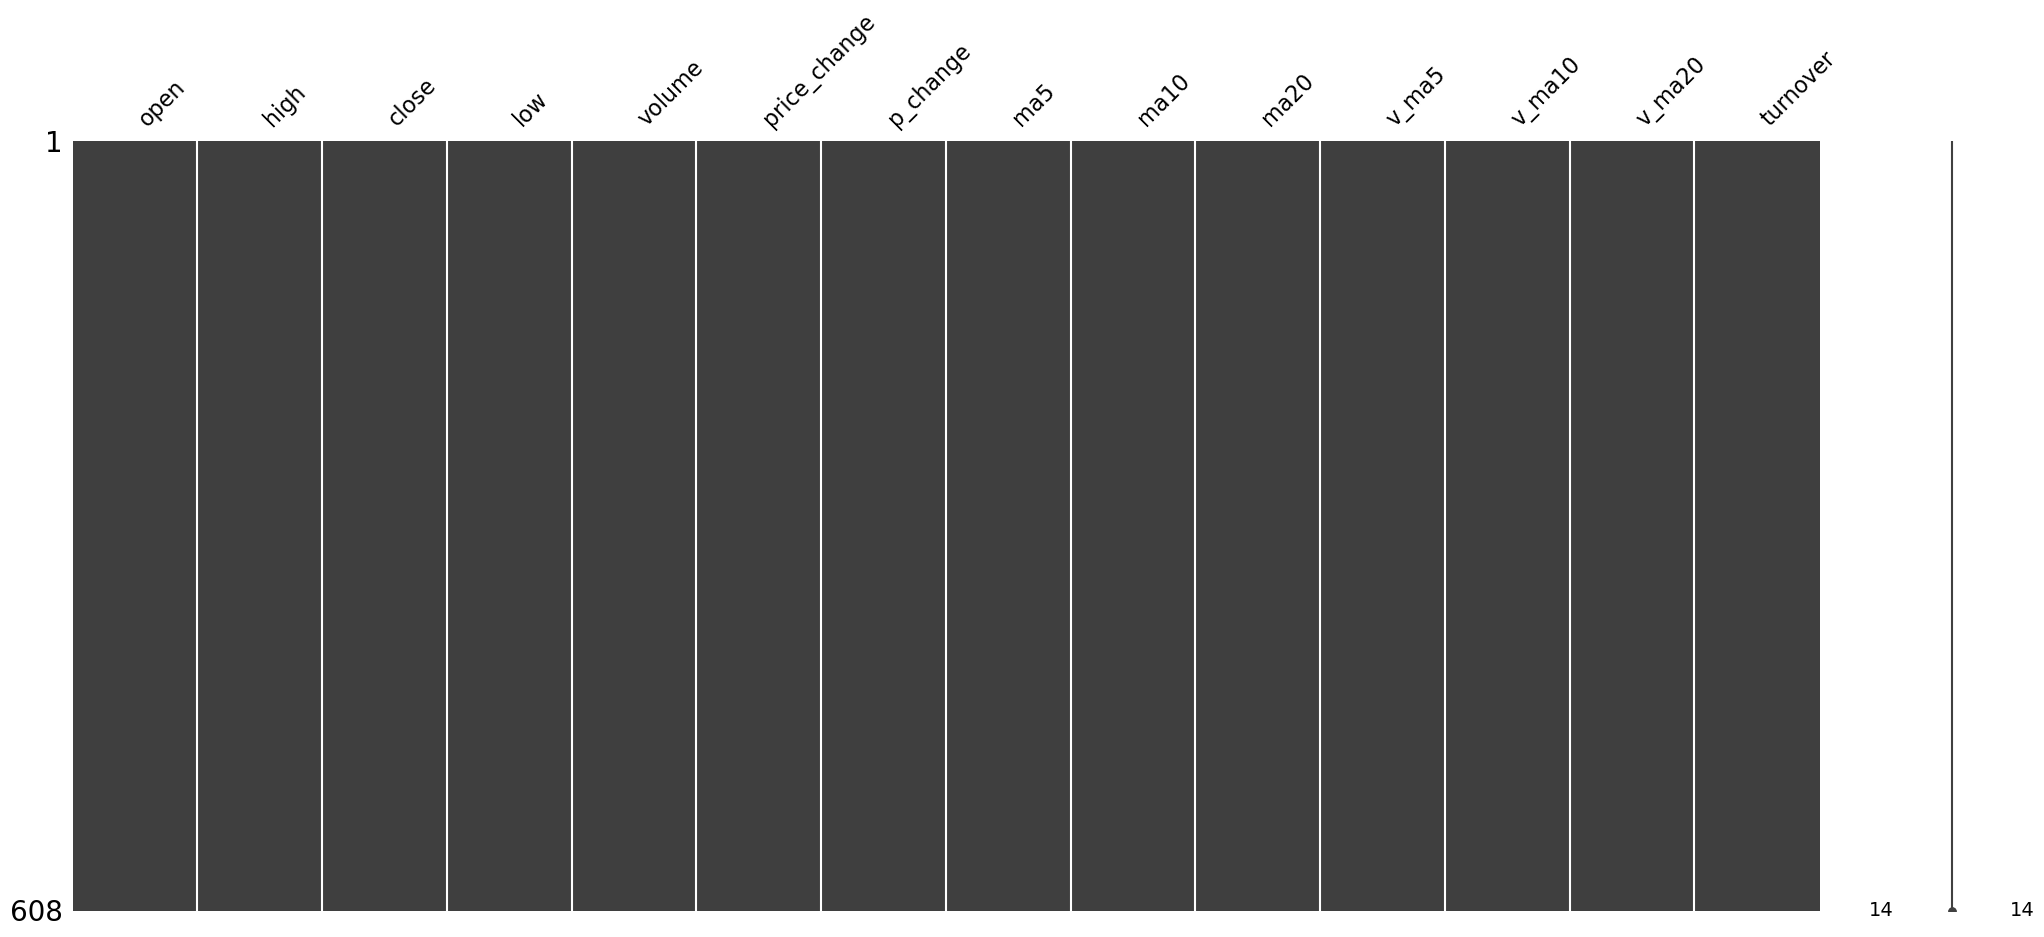

In [7]:
msno.matrix(guizhou_df)

<Axes: >

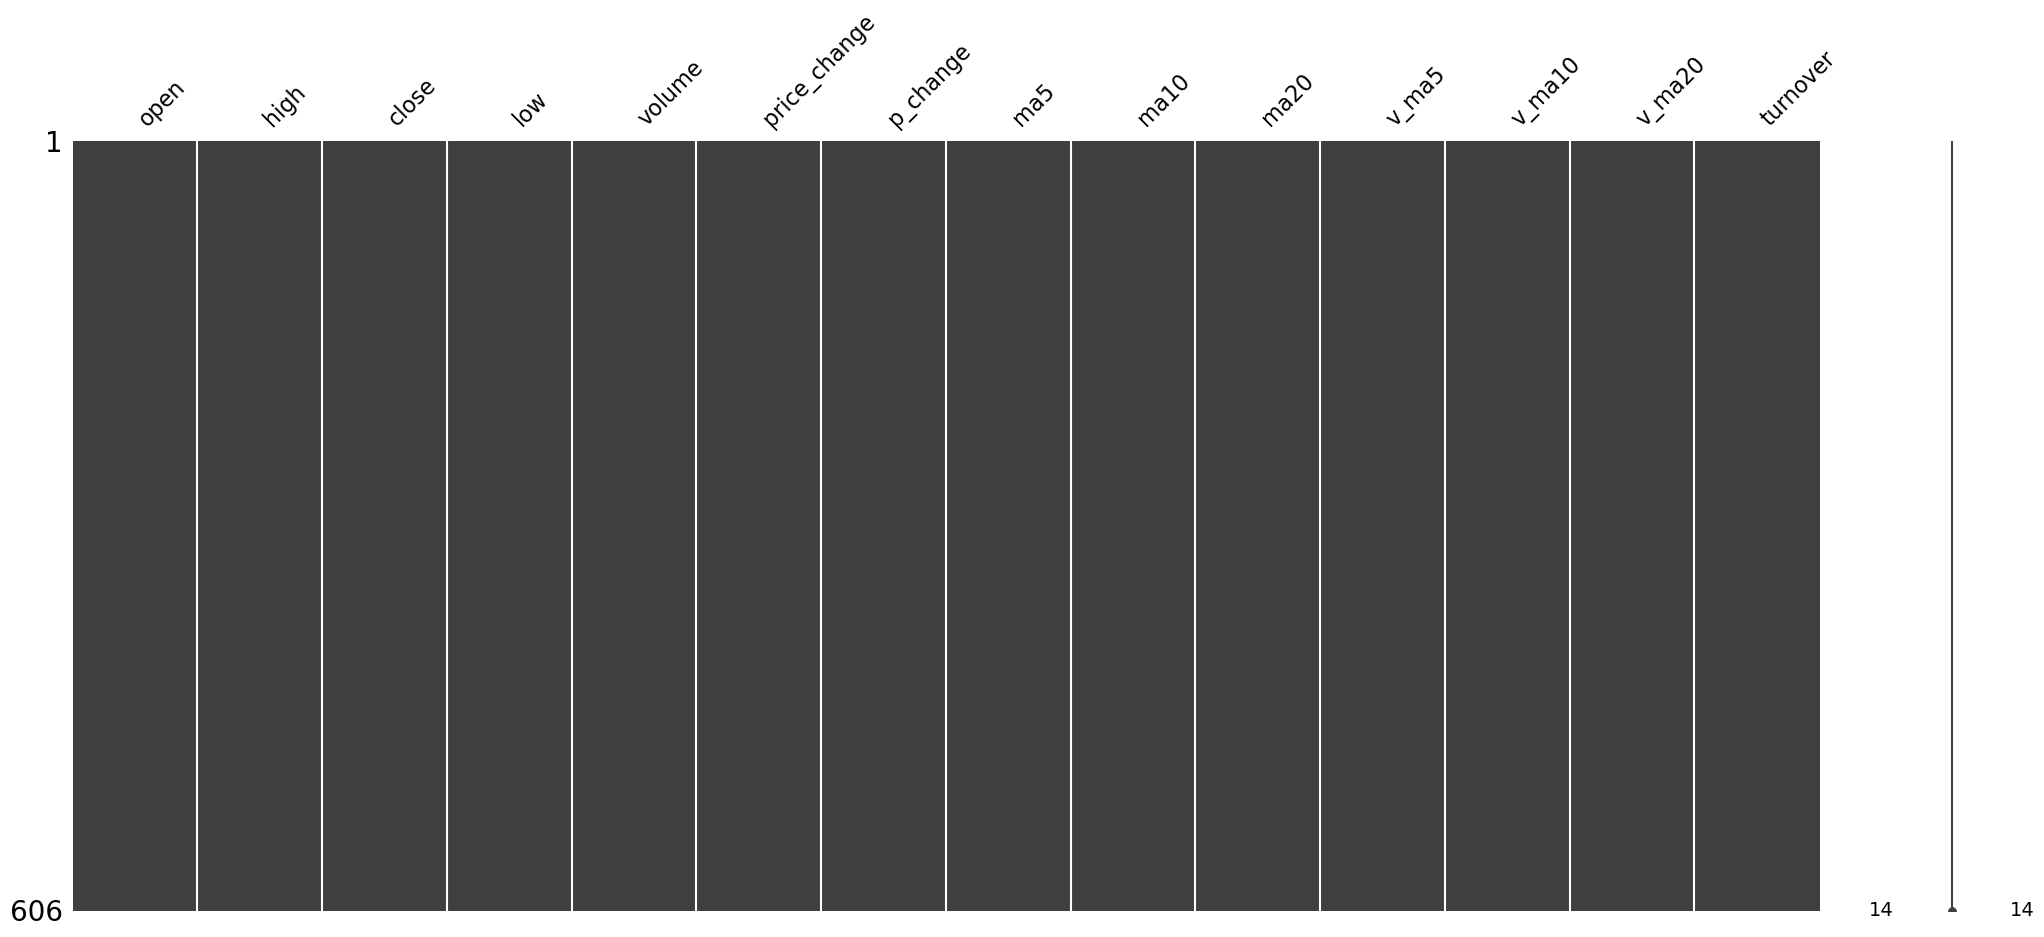

In [8]:
msno.matrix(zhangzi_df)

<Axes: >

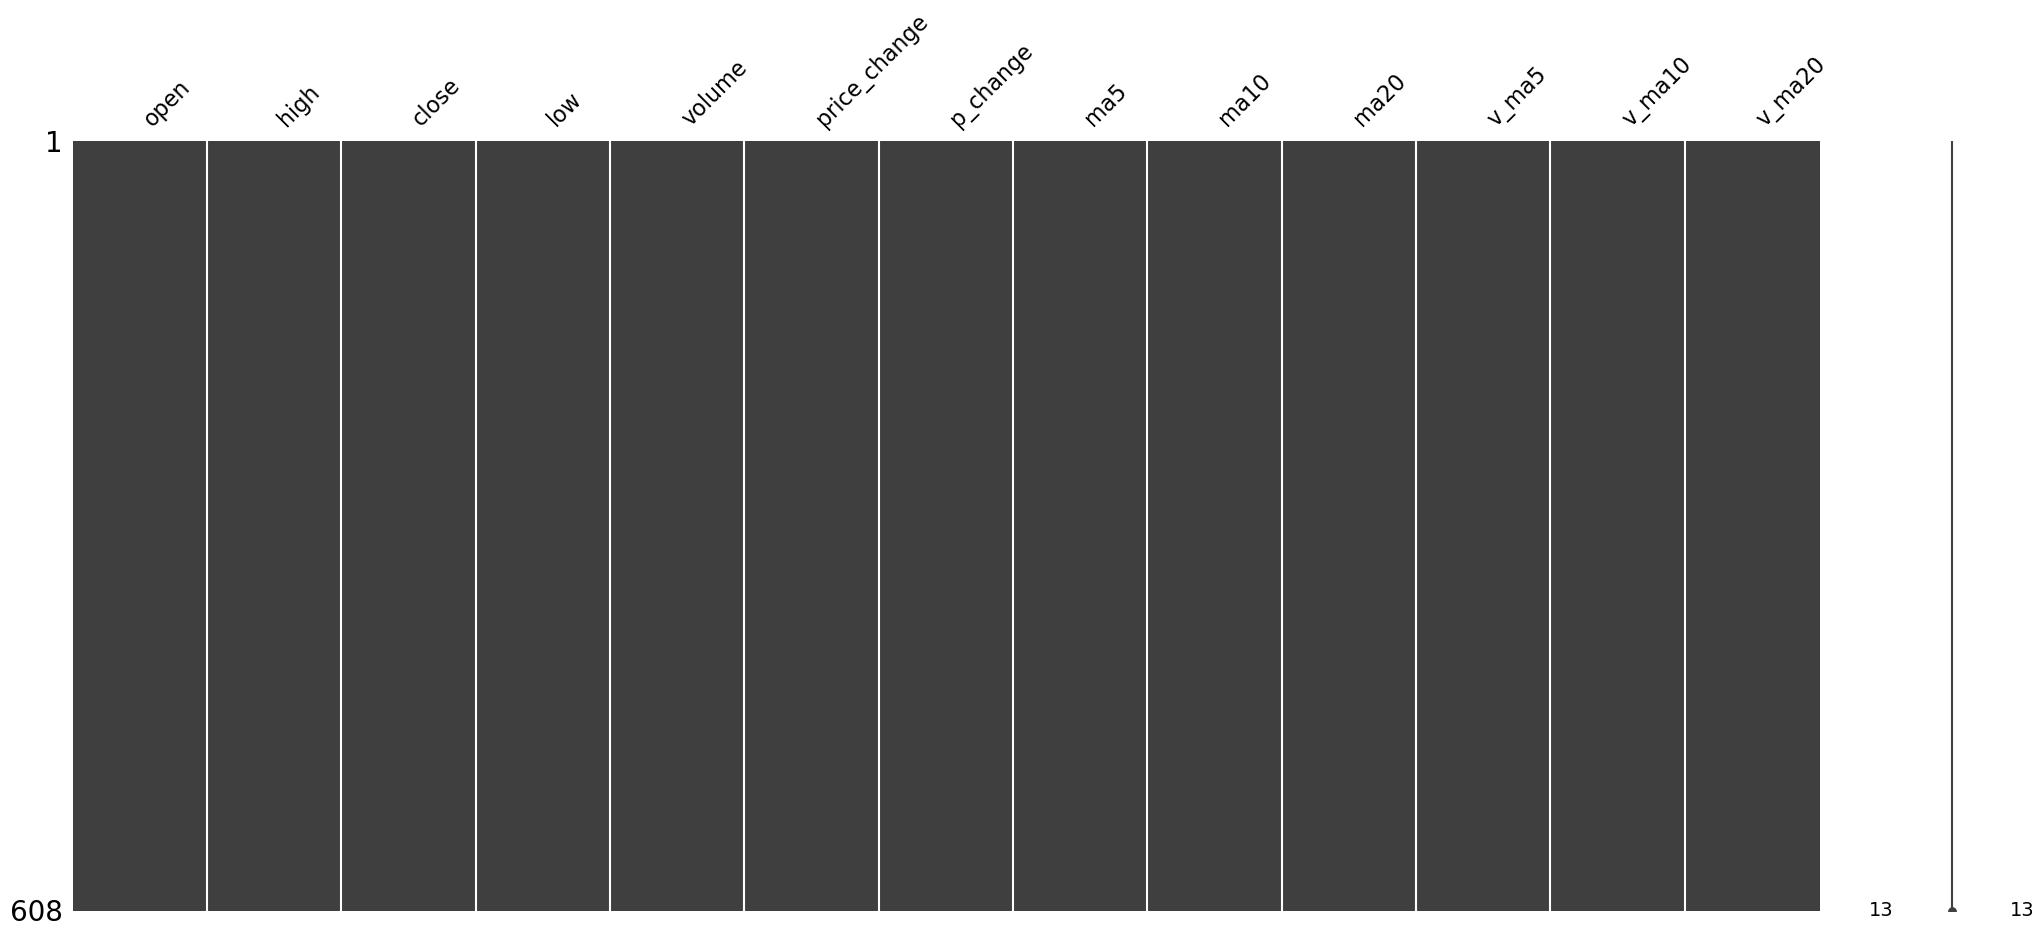

In [9]:
msno.matrix(hushen_df)

#### ***3-2 HeatMap Visualization***

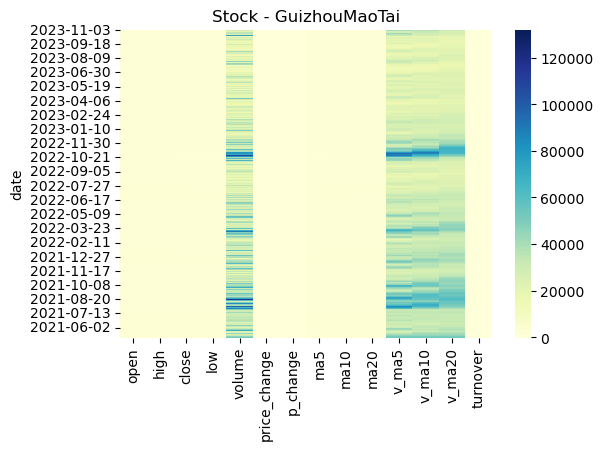

In [10]:
%matplotlib inline
plt.figure(figsize=(6, 4))
sns.heatmap(guizhou_df, cmap="YlGnBu")
plt.title("Stock - GuizhouMaoTai")
plt.show()

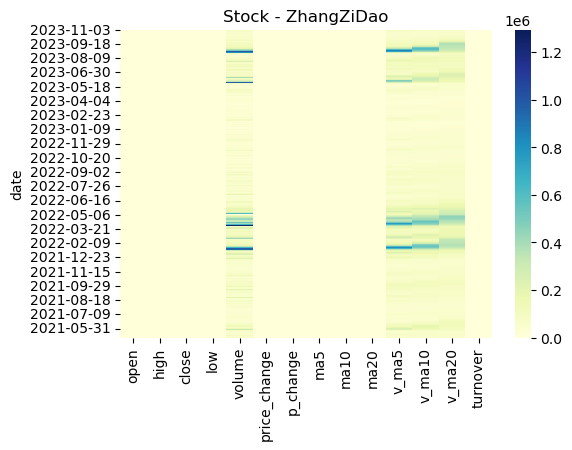

In [11]:
%matplotlib inline
plt.figure(figsize=(6, 4))
sns.heatmap(zhangzi_df, cmap="YlGnBu")
plt.title("Stock - ZhangZiDao")
plt.show()

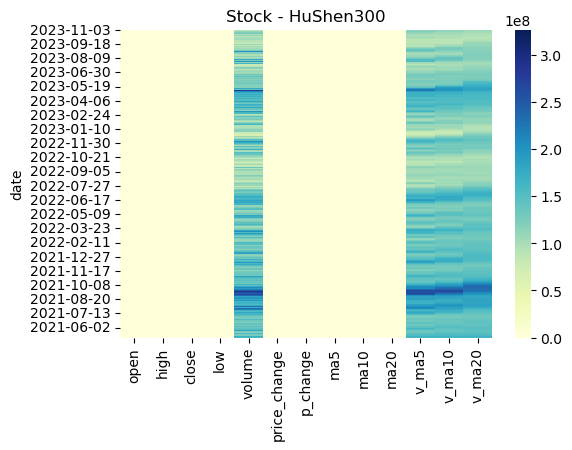

In [12]:
%matplotlib inline
plt.figure(figsize=(6, 4))
sns.heatmap(hushen_df, cmap="YlGnBu")
plt.title("Stock - HuShen300")
plt.show()

#### ***3-3 Dataset Construction***

In [13]:
def data_preprocess(df, sequence_length, batch_size):

    if len(df.columns) > 7:
        df = df.drop(['ma5'], axis=1)
        df = df.drop(['ma10'], axis=1)
        df = df.drop(['ma20'], axis=1)
        df = df.drop(['v_ma5'], axis=1)
        df = df.drop(['v_ma10'], axis=1)
        df = df.drop(['v_ma20'], axis=1)
    if 'turnover' in df.columns:
        df = df.drop(['turnover'], axis=1)

    close_max = df['close'].max()
    close_min = df['close'].min()
    df = df.apply(lambda x: (x - min(x)) / (max(x) - min(x))) 

    sequence = sequence_length
    X = []
    Y = []
    for i in range(df.shape[0] - sequence):
        X.append(np.array(df.iloc[i:(i + sequence), ].values, dtype=np.float32))
        Y.append(np.array(df.iloc[(i + sequence), 0], dtype=np.float32))

    total_len = len(Y)
    train_x, train_y = X[:total_len-sequence], Y[:total_len-sequence]
    valid_x, valid_y = X[total_len-sequence:], Y[total_len-sequence:]

    train_dataset = Stock_Dataset(train_x, train_y, transform=transforms.ToTensor())
    valid_dataset = Stock_Dataset(valid_x, valid_y, transform=transforms.ToTensor())
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

    return close_max, close_min, train_loader, valid_loader



class Stock_Dataset(Dataset):
    def __init__(self, xx, yy, transform=None):
        self.x = xx
        self.y = yy
        self.tranform = transform

    def __getitem__(self, index):
        x1 = self.x[index]
        y1 = self.y[index]
        if self.tranform != None:
            return self.tranform(x1), y1
        return x1, y1

    def __len__(self):
        return len(self.x)

### ***4 Model Costruction***

#### ***4-1 LSTM Model***

In [14]:
class LSTM_Model(nn.Module):

    def __init__(self, input_size=8, hidden_size=32, num_layers=1 , output_size=1 , dropout=0, batch_first=True):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)
        out = self.linear(hidden)
        return out

#### ***4-2 Training Func***

In [15]:
# %matplotlib inline
def plot_loss(history):
    
    loss_values = history['loss']
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def train(model, df, save_path):
    model.to(args.device)
    
    # Use MSE as Loss Func
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    close_max, close_min, train_loader, test_loader = data_preprocess(df, args.sequence_length, args.batch_size)

    bar = tqdm(total=args.epochs, desc='Epoch: 0, Loss: 0')
    
    train_loss_list = []
    epoch_list = []

    for i in tqdm(range(args.epochs)):
        total_loss = 0
        for idx, (data, label) in enumerate(train_loader):
            if args.useGPU:
                data1 = data.squeeze(1).cuda()
                pred = model(Variable(data1).cuda())
                pred = pred[1,:,:]
                label = label.unsqueeze(1).cuda()
            else:
                data1 = data.squeeze(1)
                pred = model(Variable(data1))
                pred = pred[1, :, :]
                label = label.unsqueeze(1)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss_list.append(total_loss)
        epoch_list.append(i+1)
        

        bar.set_description('Epoch: ' + str(i+1) + ' Loss: ' + str(total_loss))
        bar.update()

        if i % 10 == 0:
            torch.save({'state_dict': model.state_dict()}, save_path)
    
    loss_dict = {'loss': train_loss_list}
    plot_loss(loss_dict)
    torch.save({'state_dict': model.state_dict()}, save_path)


#### ***4-3 Training Visualization***

100%|██████████| 100/100 [00:11<00:00,  8.48it/s]████| 100/100 [00:11<00:00, 10.16it/s]


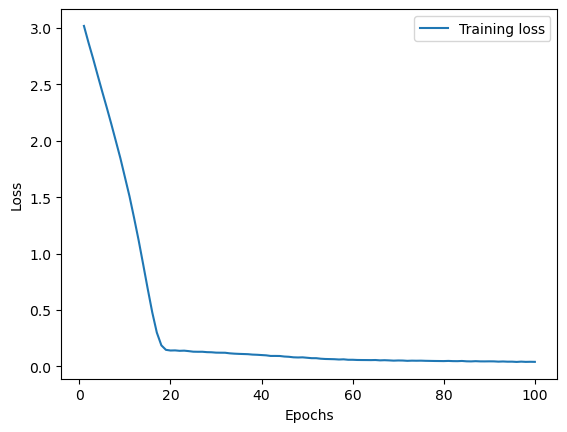

Epoch: 100 Loss: 0.03983999998308718: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


In [16]:
guizhou_model = LSTM_Model(input_size=7, hidden_size=args.hidden_size, num_layers=args.layers , output_size=1, dropout=args.dropout, batch_first=args.batch_first)
save_path = 'model/guizhou.pkl'

train(guizhou_model, guizhou_df, save_path)

100%|██████████| 100/100 [00:10<00:00,  9.56it/s]████| 100/100 [00:10<00:00,  9.84it/s]


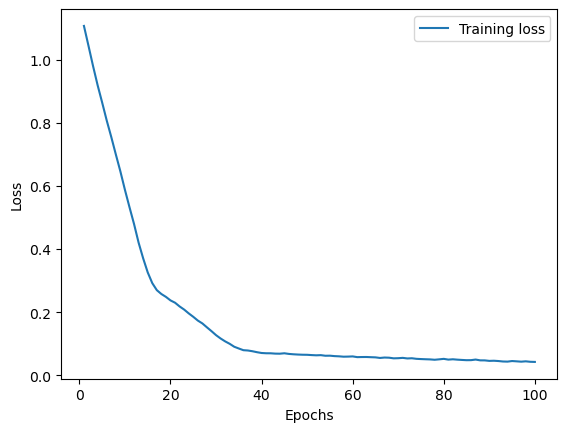

Epoch: 100 Loss: 0.04225832154043019: 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


In [17]:
zhangzi_model = LSTM_Model(input_size=7, hidden_size=args.hidden_size, num_layers=args.layers , output_size=1, dropout=args.dropout, batch_first=args.batch_first)
save_path = 'model/zhangzi.pkl'

train(zhangzi_model, zhangzi_df, save_path)

100%|██████████| 100/100 [00:10<00:00,  9.53it/s]███▉| 99/100 [00:10<00:00, 10.00it/s]


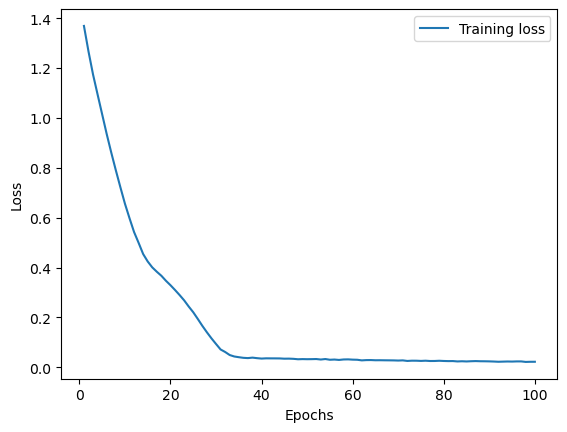

Epoch: 100 Loss: 0.02218733250629157: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


In [18]:
hushen_df_model = LSTM_Model(input_size=7, hidden_size=args.hidden_size, num_layers=args.layers , output_size=1, dropout=args.dropout, batch_first=args.batch_first)
save_path = 'model/hushen.pkl'

train(hushen_df_model, hushen_df, save_path)

### ***5 Visualization and Analysis of Results***

#### ***5-1 Validation Func***

In [44]:
def eval(ck_path, df, input_size):
    model = LSTM_Model(input_size=input_size, hidden_size=args.hidden_size, num_layers=args.layers , output_size=1)
    model.to(args.device)

    checkpoint = torch.load(ck_path)
    model.load_state_dict(checkpoint['state_dict'])

    preds = []
    labels = []

    close_max, close_min, train_loader, test_loader = data_preprocess(df, args.sequence_length, args.batch_size)
    
    for idx, (x, label) in enumerate(test_loader):
        if args.useGPU:
            x = x.squeeze(1).cuda()
        else:
            x = x.squeeze(1)

        pred = model(x)
        list = pred.data.squeeze(1).tolist()
        
        preds.extend(list[-1])
        labels.extend(label.tolist())

    # for i in range(len(preds)):
    #     print('Prediction: %.2f, Ground Truth: %.2f' % (preds[i][0] * (close_max - close_min) + close_min, labels[i] * (close_max - close_min) + close_min))

    pred_list = [i[0] for i in preds]
    label_list = labels
    time_list = range(1, args.sequence_length + 1)

    plt.plot(time_list, pred_list, label='Prediction')
    plt.plot(time_list, label_list, label='Ground Truth')
    plt.xlabel('Time')
    plt.ylabel('Loss')
    plt.ylim(min([min(pred_list),min(label_list)])-0.1, max([max(pred_list),max(label_list)])+0.1)
    plt.legend()

        

#### ***5-2 Validation Visualization***

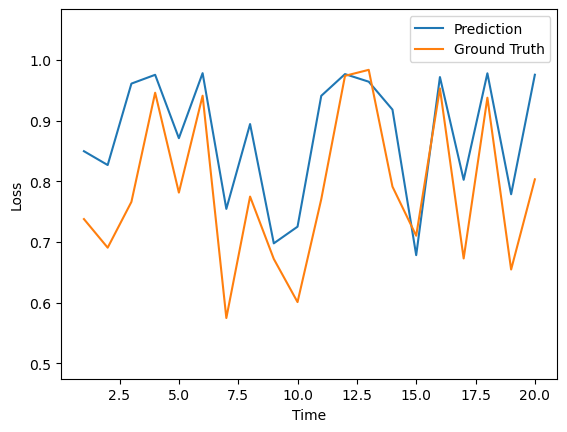

In [45]:
ck_path = 'model/guizhou.pkl'
eval(ck_path, guizhou_df, 7)

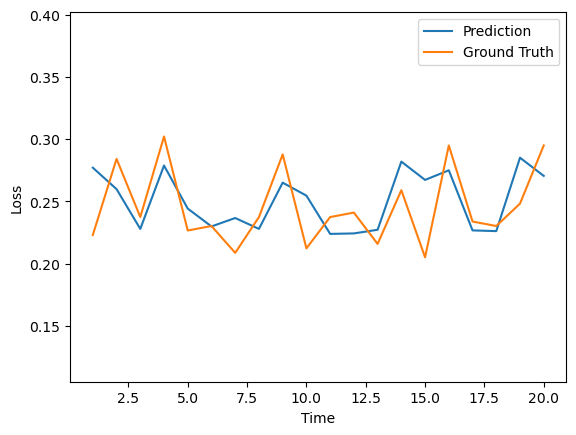

In [46]:
ck_path = 'model/zhangzi.pkl'
eval(ck_path, zhangzi_df, 7)

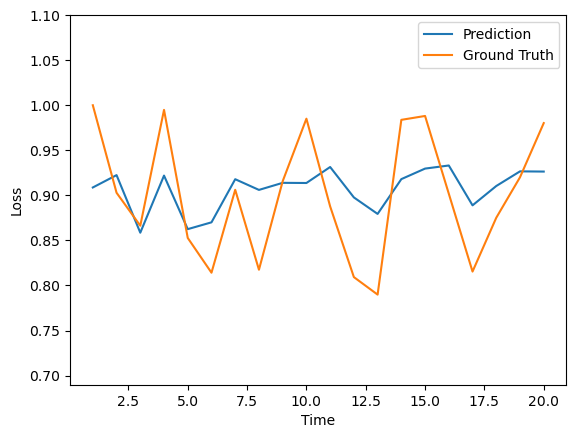

In [52]:
ck_path = 'model/hushen.pkl'
eval(ck_path, hushen_df, 7)

### ***6 Prediction***

***Use efinance package to get latest data of these stocks***

In [40]:
import efinance as ef

def predict_stock(stock_code, ck_path):
    begin_date = '2023101'
    end_date = '20231106'

    # get data
    new_guizhou_df = ef.stock.get_quote_history(stock_code, beg=begin_date, end=end_date)

    new_guizhou_df = new_guizhou_df.drop(['涨跌额'], axis=1)
    new_guizhou_df = new_guizhou_df.drop(['涨跌幅'], axis=1)
    new_guizhou_df = new_guizhou_df.drop(['换手率'], axis=1)
    new_guizhou_df = new_guizhou_df.drop(['股票名称'], axis=1)
    new_guizhou_df = new_guizhou_df.drop(['股票代码'], axis=1)
    new_guizhou_df = new_guizhou_df.drop(['日期'], axis=1)

    new_guizhou_df.columns = ['open', 'close', 'high', 'low', 'volume', 'price_change', 'p_change']
    # new_guizhou_df.describe()

    eval(ck_path, new_guizhou_df, 7)

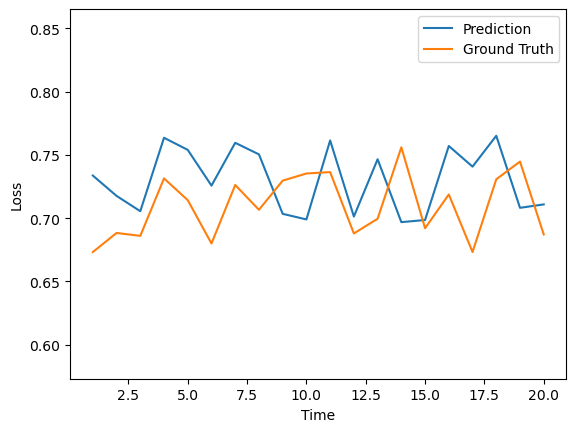

In [53]:
stock_code = '600519'
ck_path = 'model/guizhou.pkl'

predict_stock(stock_code, ck_path)

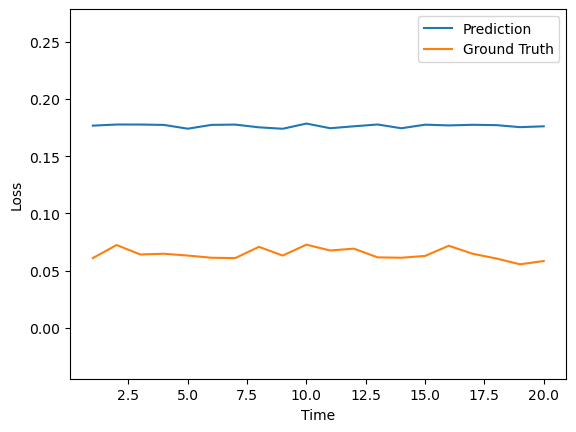

In [54]:
stock_code = '002069'
ck_path = 'model/zhangzi.pkl'

predict_stock(stock_code, ck_path)

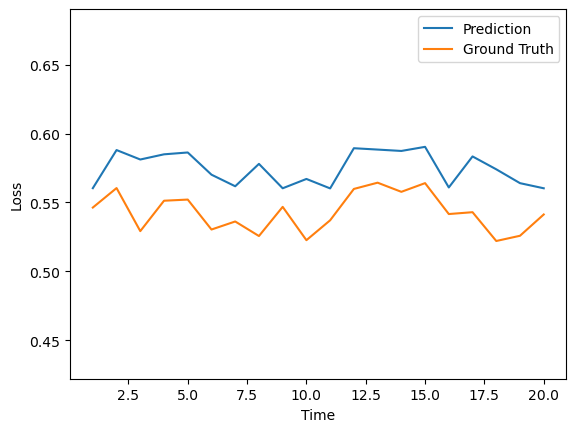

In [55]:
stock_code = '399300'
ck_path = 'model/hushen.pkl'

predict_stock(stock_code, ck_path)